# Genre predictor

In [ ]:
# prompt: montar el drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Librerías básicas de manejo de datos
import numpy as np
import pandas as pd

# Modelos basados en árboles y otros de sklearn
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from collections import Counter

# Modelos de XGBoost, LightGBM y CatBoost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from collections import Counter


RESULTS

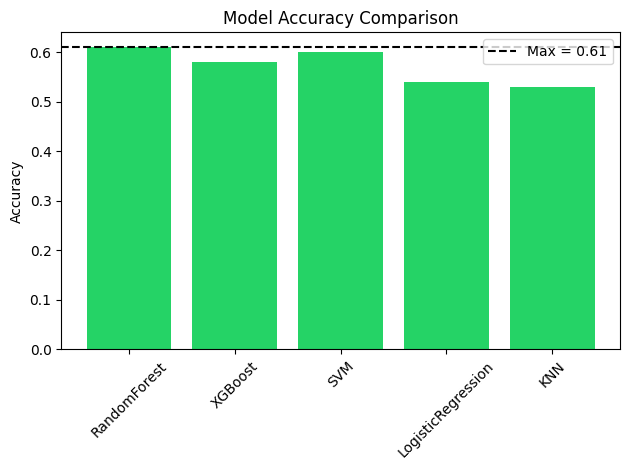

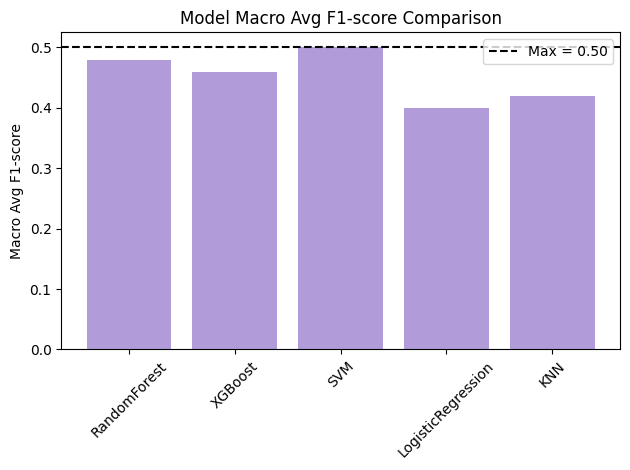

In [ ]:
import matplotlib.pyplot as plt

# Data
results = {
    "RandomForest": {"accuracy": 0.61, "macro_avg_f1": 0.48},
    "XGBoost": {"accuracy": 0.58, "macro_avg_f1": 0.46},
    "SVM": {"accuracy": 0.60, "macro_avg_f1": 0.50},
    "LogisticRegression": {"accuracy": 0.54, "macro_avg_f1": 0.40},
    "KNN": {"accuracy": 0.53, "macro_avg_f1": 0.42}
}

models = list(results.keys())
accuracy = [results[m]['accuracy'] for m in models]
macro_f1 = [results[m]['macro_avg_f1'] for m in models]

# WhatsApp green: #25D366, Pastel violet: #B19CD9

# Accuracy Comparison
plt.figure()
plt.bar(models, accuracy, color='#25D366')
max_acc = max(accuracy)
plt.axhline(max_acc, linestyle='--', color="black", label=f'Max = {max_acc:.2f}')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Macro Avg F1-score Comparison
plt.figure()
plt.bar(models, macro_f1, color='#B19CD9')
max_f1 = max(macro_f1)
plt.axhline(max_f1, linestyle='--',color="black", label=f'Max = {max_f1:.2f}')
plt.ylabel('Macro Avg F1-score')
plt.title('Model Macro Avg F1-score Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

ENTRENAMIENTO

In [ ]:

%cd /content/drive/MyDrive/Colab Notebooks/PROY 3

data_ini = pd.read_csv("dataset_pred_genres_57.csv", parse_dates=['release_date'])
data = data_ini[~data_ini["main_genre"].isin(["christmas", "female vocalists", "fip"])].copy()
data["release_date"] = pd.to_datetime(
    data["release_date"], format="%Y-%m-%d", errors="coerce"
)

data["month"] = data["release_date"].dt.month
data["dayofweek"] = data["release_date"].dt.dayofweek

data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

data['dayofweek_sin'] = np.sin(2 * np.pi * data['dayofweek'] / 7)
data['dayofweek_cos'] = np.cos(2 * np.pi * data['dayofweek'] / 7)

data.drop(["release_date", "month", "dayofweek"], axis=1, inplace=True)

/content/drive/MyDrive/Colab Notebooks/PROY 3


# Lista de variables a utilizar

In [ ]:
features = [
    "new_popularity_2025",
    "acousticness",
    "danceability",
    "duration_ms",
    "energy",
    "explicit",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
    "mode",
    "speechiness",
    "tempo",
    "valence",
    "year",
    "month_cos",
    "month_sin",
    "dayofweek_cos",
    "dayofweek_sin",
    "featuring_cat"
]

target = "main_genre"


# Preparación de datos para modelo

In [ ]:


# prompt: guardar en data un subset de data que sean solo los 15 main_genres con mayor value counts
data["featuring_cat"] = data["featuring_cat"].apply(lambda x: 0 if x == "No" else 1)

# Obtener los 15 géneros principales con mayor frecuencia
top_15_genres = data['main_genre'].value_counts().nlargest(15).index
# Crear un subconjunto de datos con solo los 15 géneros principales
data = data[data['main_genre'].isin(top_15_genres)]

X = data[features].copy()

# --- Preprocesamiento ---

# Aplicar LabelEncoder para convertir las clases en numéricas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data[target])

# Estandarizar las features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# División de datos

In [ ]:
# --- División de datos ---
# Aquí usamos stratify=y para mantener la distribución de clases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Experimento 1: Balanced Training ---
min_count = 2000  # mínimo de muestras que quieres por clase
class_counts = Counter(y_train)
sampling_strategy = {
    cls: min_count for cls, count in class_counts.items() if count < min_count
}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)


In [ ]:
import tensorflow as tf
import os

# Verifica si hay GPUs disponibles con TensorFlow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Permite la asignación dinámica de memoria (memory growth)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Se detectaron {len(gpus)} GPU(s):")
        for gpu in gpus:
            print("  -", gpu)
    except RuntimeError as e:
        print("Error al configurar la GPU:", e)
else:
    print("No se detectó ninguna GPU.")


Se detectaron 1 GPU(s):
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
# ===============================
# Configuración e importaciones GPU
# ===============================
import numpy as np
import pandas as pd

# Importar módulos de RAPIDS cuML para modelos GPU (asegúrate de tener instalado RAPIDS en Colab)
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.svm import SVC as cuSVC
from cuml.linear_model import LogisticRegression as cuLR
from cuml.neighbors import KNeighborsClassifier as cuKNN

# Importar XGBoost y LightGBM, que permiten configurar el uso de GPU
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")  # Suprime todas las advertencias

# Importar herramientas de validación y métricas
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report
import gc

# Definición de grid de parámetros para cada modelo (ya acotados)
model_grids_gpu = {
    "RandomForest": {
        "model": cuRF(random_state=42),
        "params": {
            "n_estimators": [100, 200],  # Reducción a 2 valores
            "max_depth": [10, 20, 30]      # Se eliminó 'None' (no aceptado)
        }
    },
    "XGBoost": {
        "model": XGBClassifier(tree_method="gpu_hist", predictor="gpu_predictor",
                               eval_metric="mlogloss", random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01],
            "max_depth": [3, 5],
            "subsample": [0.5, 1.0],
            "colsample_bytree": [1.0],
            "gamma": [1],
            "reg_alpha": [0, 0.1],
            "reg_lambda": [1, 10]
        }
    },
    "SVM": {
        "model": cuSVC(random_state=42),
        "params": {
            "C": [0.1, 1, 10]
        }
    },
    "LogisticRegression": {
        "model": cuLR(),
        "params": {
            "C": [0.01, 0.1, 1, 10]
        }
    },
    "KNN": {
        "model": cuKNN(),
        "params": {
            "n_neighbors": [3, 5, 7, 11]
        }
    }

}

# Configuración de validación (KFold)
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Para cada modelo, se realiza GridSearchCV en dos escenarios:
# 1. Con datos balanceados (X_train_bal, y_train_bal)
# 2. Con datos sin balancear (X_train, y_train)
for name, config in model_grids_gpu.items():
    print(f"\n=====================================\nModelo: {name}")

    # GridSearchCV para datos balanceados
    print("\n-- Balanced Training --")
    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        scoring="accuracy",
        cv=kf,
        verbose=0,
        n_jobs=1  # Se usa n_jobs=1 para evitar problemas de serialización en modelos GPU
    )
    grid.fit(X_train_bal, y_train_bal)
    print("Mejores parámetros:", grid.best_params_)
    y_pred_bal = grid.predict(X_test)
    print("Reporte de clasificación (Balanced):")
    print(classification_report(y_test, y_pred_bal))

    # Liberar memoria tras entrenar cada modelo
    del grid
    gc.collect()

    # GridSearchCV para datos sin balancear
    print("\n-- Relative Partition Training --")
    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        scoring="accuracy",
        cv=kf,
        verbose=0,
        n_jobs=1
    )
    grid.fit(X_train, y_train)
    print("Mejores parámetros:", grid.best_params_)
    y_pred_rel = grid.predict(X_test)
    print("Reporte de clasificación (Relative Partition):")
    print(classification_report(y_test, y_pred_rel))

    del grid
    gc.collect()



Modelo: RandomForest

-- Balanced Training --
Mejores parámetros: {'max_depth': 30, 'n_estimators': 200}
Reporte de clasificación (Balanced):
              precision    recall  f1-score   support

           0       0.85      0.22      0.35       303
           1       0.59      0.27      0.37       289
           2       0.57      0.28      0.38      1036
           3       0.65      0.23      0.34       400
           4       0.57      0.09      0.16       496
           5       0.93      0.79      0.86       314
           6       0.61      0.51      0.55       862
           7       0.25      0.03      0.05       291
           8       0.74      0.76      0.75      1981
           9       0.81      0.45      0.58       321
          10       0.51      0.62      0.56      3063
          11       0.50      0.45      0.47       639
          12       0.60      0.87      0.71      4951
          13       0.61      0.15      0.24       912
          14       0.79      0.97      0.87   

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import math

config = {
    "model": RandomForestClassifier(random_state=42),  # Modelo para CPU
    "params": {
        "n_estimators": [200,300,400],
        "max_depth": [30,40],
        "max_features": [1/math.sqrt(X_train.shape[1])],
        "bootstrap": [True],
        # En scikit-learn se usa el parámetro 'criterion' en lugar de 'split_criterion'
        # Asumiendo que 1 en cuML correspondía a 'entropy'
        "criterion": ["entropy"]
    }
}


from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report
import gc

kf = KFold(n_splits=3, shuffle=True, random_state=42)
print(f"\n=====================================\nModelo: RandomForest")

# GridSearchCV para datos balanceados
print("\n-- Balanced Training --")
grid = GridSearchCV(
    estimator=config["model"],
    param_grid=config["params"],
    scoring="accuracy",
    cv=kf,
    verbose=2,
    n_jobs=1  # Importante para evitar errores con cuML
)
grid.fit(X_train_bal, y_train_bal)

print("\n✅ Mejores parámetros (Balanced):", grid.best_params_)
y_pred_bal = grid.predict(X_test)
print("📊 Reporte de clasificación (Balanced):")
print(classification_report(y_test, y_pred_bal))




Modelo: RandomForest

-- Balanced Training --
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END bootstrap=True, criterion=entropy, max_depth=30, max_features=0.22360679774997896, n_estimators=200; total time= 1.1min
[CV] END bootstrap=True, criterion=entropy, max_depth=30, max_features=0.22360679774997896, n_estimators=200; total time= 1.0min
[CV] END bootstrap=True, criterion=entropy, max_depth=30, max_features=0.22360679774997896, n_estimators=200; total time=  58.2s
[CV] END bootstrap=True, criterion=entropy, max_depth=30, max_features=0.22360679774997896, n_estimators=300; total time= 1.5min
[CV] END bootstrap=True, criterion=entropy, max_depth=30, max_features=0.22360679774997896, n_estimators=300; total time= 1.5min
[CV] END bootstrap=True, criterion=entropy, max_depth=30, max_features=0.22360679774997896, n_estimators=300; total time= 1.7min
[CV] END bootstrap=True, criterion=entropy, max_depth=30, max_features=0.22360679774997896, n_estimators=400; total tim

# Número de clases óptimo

In [ ]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import math
import pandas as pd

# recargar los datos
%cd /content/drive/MyDrive/Colab Notebooks/

data_ini = pd.read_csv("dataset_pred_genres_57.csv", parse_dates=['release_date'])
data = data_ini[~data_ini["main_genre"].isin(["christmas", "female vocalists", "fip"])].copy()
data["release_date"] = pd.to_datetime(
    data["release_date"], format="%Y-%m-%d", errors="coerce"
)

data["month"] = data["release_date"].dt.month
data["dayofweek"] = data["release_date"].dt.dayofweek

data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

data['dayofweek_sin'] = np.sin(2 * np.pi * data['dayofweek'] / 7)
data['dayofweek_cos'] = np.cos(2 * np.pi * data['dayofweek'] / 7)

data.drop(["release_date", "month", "dayofweek"], axis=1, inplace=True)



features = [
    "new_popularity_2025",
    "acousticness",
    "danceability",
    "duration_ms",
    "energy",
    "explicit",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
    "mode",
    "speechiness",
    "tempo",
    "valence",
    "year",
    "month_cos",
    "month_sin",
    "dayofweek_cos",
    "dayofweek_sin",
    "featuring_cat"
]

target = "main_genre"

# prompt: guardar en data un subset de data que sean solo los 15 main_genres con mayor value counts
data["featuring_cat"] = data["featuring_cat"].apply(lambda x: 0 if x == "No" else 1)


# --- Parámetros ya encontrados como óptimos ---
best_params = {
    'bootstrap': True,
    'criterion': 'entropy',
    'max_depth': 40,
    'max_features': 1/math.sqrt(X_train.shape[1]),  # 1/math.sqrt(n_features)
    'n_estimators': 300
}

# Diccionario para almacenar los training sets balanceados
balanced_train_sets = {}

# Lista para guardar resultados de accuracy
results = []

for n_classes in range(15, 51, 5):
    # 1) Subconjunto de los top n_classes géneros
    top_genres = data['main_genre'].value_counts().nlargest(n_classes).index
    subset = data[data['main_genre'].isin(top_genres)]

    # 2) Preprocesamiento
    X = subset[features].copy()
    y = LabelEncoder().fit_transform(subset[target])
    X_scaled = StandardScaler().fit_transform(X)

    # 3) División train/test (manteniendo proporción de clases)
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_scaled, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    # 4) Oversampling para lograr al menos 2000 muestras por clase
    class_counts = Counter(y_tr)
    sampling_strategy = {cls: 2000 for cls, cnt in class_counts.items() if cnt < 2000}
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_tr_bal, y_tr_bal = ros.fit_resample(X_tr, y_tr)

    # Guardar en el diccionario
    balanced_train_sets[n_classes] = (X_tr_bal, y_tr_bal)

    # 5) Entrenar y evaluar con el modelo ya configurado
    model = RandomForestClassifier(random_state=42, **best_params)
    model.fit(X_tr_bal, y_tr_bal)
    y_pred = model.predict(X_te)
    print("📊 Reporte de clasificación (Balanced):")
    print(classification_report(y_te, y_pred))
    acc = accuracy_score(y_te, y_pred)

    report = classification_report(y_te, y_pred, output_dict=True, zero_division=0)
    macro = report["macro avg"]
    weighted = report["weighted avg"]

    # Guardar todo en resultados
    results.append({
        "n_classes":          n_classes,
        "accuracy":           acc,
        "macro_precision":    macro["precision"],
        "macro_recall":       macro["recall"],
        "macro_f1":           macro["f1-score"],
        "weighted_precision": weighted["precision"],
        "weighted_recall":    weighted["recall"],
        "weighted_f1":        weighted["f1-score"]
    })

# Montar DataFrame para comparar
results_df = pd.DataFrame(results)
print(results_df)


/content/drive/MyDrive/Colab Notebooks
📊 Reporte de clasificación (Balanced):
              precision    recall  f1-score   support

           0       0.78      0.37      0.50       303
           1       0.60      0.34      0.43       289
           2       0.59      0.32      0.41      1036
           3       0.72      0.25      0.37       400
           4       0.63      0.13      0.21       496
           5       0.94      0.85      0.89       314
           6       0.63      0.51      0.56       862
           7       0.33      0.03      0.06       291
           8       0.74      0.79      0.77      1981
           9       0.81      0.46      0.59       321
          10       0.52      0.63      0.57      3063
          11       0.50      0.45      0.47       639
          12       0.62      0.86      0.72      4951
          13       0.63      0.19      0.29       912
          14       0.97      0.96      0.97       328

    accuracy                           0.63     16186
  

# Almacenar el modelo final

In [ ]:
# prompt: cargar el mejor modelo best_params = {
# #     'bootstrap': True,
# #     'criterion': 'entropy',
# #     'max_depth': 40,
# #     'max_features': 1/math.sqrt(X_train.shape[1]),  # 1/math.sqrt(n_features)
# #     'n_estimators': 300
# # }
# # model = RandomForestClassifier(random_state=42, **best_params). Debes volver a cargar los datos para 15 clases

import math
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import math
import pandas as pd

best_params = {
    'bootstrap': True,
    'criterion': 'entropy',
    'max_depth': 40,
    'max_features': 1/math.sqrt(X_train.shape[1]),  # 1/math.sqrt(n_features)
    'n_estimators': 300
}


results = []


# 1) Subconjunto de los top n_classes géneros
top_genres = data['main_genre'].value_counts().nlargest(15).index
subset = data[data['main_genre'].isin(top_genres)]

# 2) Preprocesamiento
X = subset[features].copy()
y = LabelEncoder().fit_transform(subset[target])
X_scaled = StandardScaler().fit_transform(X)

# 3) División train/test (manteniendo proporción de clases)
X_tr, X_te, y_tr, y_te = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4) Oversampling para lograr al menos 2000 muestras por clase
class_counts = Counter(y_tr)
sampling_strategy = {cls: 2000 for cls, cnt in class_counts.items() if cnt < 2000}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_tr_bal, y_tr_bal = ros.fit_resample(X_tr, y_tr)


# 5) Entrenar y evaluar con el modelo ya configurado
model = RandomForestClassifier(random_state=42, **best_params)
model.fit(X_tr_bal, y_tr_bal)
y_pred = model.predict(X_te)
print(f"Resultados para {15} clases:") # Agregamos esto para una mejor visualización
print("📊 Reporte de clasificación (Balanced):")
print(classification_report(y_te, y_pred))
acc = accuracy_score(y_te, y_pred)

report = classification_report(y_te, y_pred, output_dict=True, zero_division=0)
macro = report["macro avg"]
weighted = report["weighted avg"]

# Guardar todo en resultados
results.append({
    "n_classes":          15,
    "accuracy":           acc,
    "macro_precision":    macro["precision"],
    "macro_recall":       macro["recall"],
    "macro_f1":           macro["f1-score"],
    "weighted_precision": weighted["precision"],
    "weighted_recall":    weighted["recall"],
    "weighted_f1":        weighted["f1-score"]
})

# Montar DataFrame para comparar
results_df = pd.DataFrame(results)
results_df


Resultados para 15 clases:
📊 Reporte de clasificación (Balanced):
              precision    recall  f1-score   support

           0       0.78      0.37      0.50       303
           1       0.60      0.34      0.43       289
           2       0.59      0.32      0.41      1036
           3       0.72      0.25      0.37       400
           4       0.63      0.13      0.21       496
           5       0.94      0.85      0.89       314
           6       0.63      0.51      0.56       862
           7       0.33      0.03      0.06       291
           8       0.74      0.79      0.77      1981
           9       0.81      0.46      0.59       321
          10       0.52      0.63      0.57      3063
          11       0.50      0.45      0.47       639
          12       0.62      0.86      0.72      4951
          13       0.63      0.19      0.29       912
          14       0.97      0.96      0.97       328

    accuracy                           0.63     16186
   macro avg  

,n_classes,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
0,15,0.62517,0.666929,0.476591,0.521508,0.627715,0.62517,0.596601


# Predicción de unknown del dataset completo

In [ ]:
# prompt: best_params = {
#     'bootstrap': True,
#     'criterion': 'entropy',
#     'max_depth': 40,
#     'max_features': 1/math.sqrt(X_train.shape[1]),  # 1/math.sqrt(n_features)
#     'n_estimators': 300
# }
# model = RandomForestClassifier(random_state=42, **best_params)
# Ahora que sé modelo es mejor. Quiero predecir del dataset "minable_view_definitive_2.csv" que está en la misma ruta de dataset_pred_genres.csv, el verdadero valor de las filas cuyo main_genre es "unknown", y también quiero guardarme la confianza (confidence) de la predicción. mask: selecciona sólo los Unknown.
# scaler.transform: usa el mismo escalador que en entrenamiento (no vuelvas a hacer fit).
# predict_proba: devuelve un array donde cada fila es la distribución de probabilidad sobre todas las clases.
# .argmax(axis=1) te da el índice de la clase con mayor probabilidad, y .max(axis=1) la probabilidad misma.
# label_encoder.inverse_transform convierte esos índices de vuelta al nombre de género.
# Finalmente añades dos columnas nuevas:
# "imputed_genre" con la etiqueta predicha
# "confidence" con el valor de probabilidad (entre 0 y 1)
# El objetivo final sería retornar el dataset completo, ten encuenta que la predicción se añadirá en una columna nueva "imputed genre", que deberá ser inicializada como "not required" ya que la idea es que todas las filas que tengan un main_genre distinto de "unknown" no se necesiten predecir

import math
import pandas as pd
from sklearn.metrics import accuracy_score

# ... (código anterior) ...

# Carga del dataset "minable_view_definitive_2.csv"
minable_data = pd.read_csv("minable_view.csv", parse_dates=['release_date'])

# Preprocesamiento de minable_data (igual que el dataset de entrenamiento)
minable_data["release_date"] = pd.to_datetime(minable_data["release_date"], format="%Y-%m-%d", errors="coerce")
minable_data["month"] = minable_data["release_date"].dt.month
minable_data["dayofweek"] = minable_data["release_date"].dt.dayofweek
minable_data['month_sin'] = np.sin(2 * np.pi * minable_data['month'] / 12)
minable_data['month_cos'] = np.cos(2 * np.pi * minable_data['month'] / 12)
minable_data['dayofweek_sin'] = np.sin(2 * np.pi * minable_data['dayofweek'] / 7)
minable_data['dayofweek_cos'] = np.cos(2 * np.pi * minable_data['dayofweek'] / 7)
#minable_data.drop(["release_date", "month", "dayofweek"], axis=1, inplace=True)
minable_data["featuring_cat"] = minable_data["featuring_cat"].apply(lambda x: 0 if x == "No" else 1)

# Seleccionar las características y aplicar el mismo escalador
X_minable = minable_data[features].copy()
X_minable_scaled = scaler.transform(X_minable)  # Usar el scaler del entrenamiento

# Crear una máscara para seleccionar las filas con 'main_genre' igual a "unknown"
mask = minable_data["main_genre"] == "unknown"

# Inicializar columnas "imputed_genre" y "confidence"
minable_data["imputed_genre"] = "not required"
minable_data["confidence"] = 0

# Realizar la predicción solo en las filas "unknown"
if X_minable_scaled.shape[0] > 0:
  if mask.sum()>0:
    probabilities = model.predict_proba(X_minable_scaled[mask])
    predicted_indices = probabilities.argmax(axis=1)
    confidence_values = probabilities.max(axis=1)
    predicted_genres = label_encoder.inverse_transform(predicted_indices)

    minable_data.loc[mask, "imputed_genre"] = predicted_genres
    minable_data.loc[mask, "confidence"] = confidence_values



<ipython-input-10-1083afe93c76>:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.22333333 0.63333333 0.42333333 ... 0.33666667 0.31666667 0.42      ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  minable_data.loc[mask, "confidence"] = confidence_values


In [ ]:
pd.set_option('display.max_columns', None)

#Retornar el dataset completo
minable_data


,id,track_name,artist_name,new_popularity_2025,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity_2021,release_date,speechiness,tempo,valence,year,genres,main_genre,subgenre_1,subgenre_2,genres_artists,acousticness_cat,danceability_cat,energy_cat,explicit_cat,instrumentalness_cat,liveness_cat,loudness_cat,speechiness_cat,tempo_cat,valence_cat,month_cat,featuring_cat,popularity_2021_cat,duration_cat,key_cat,imputed_date_cat,mode_cat,year_cat,genres_from_artists_cat,popularity_2025_cat,album,popularity_2024,popularity_2024_cat,month,dayofweek,month_sin,month_cos,dayofweek_sin,dayofweek_cos,imputed_genre,confidence
0,0cS0A1fUEUd1EW3FcF8AEI,Keep A Song In Your Soul,Mamie Smith,18,0.991000,0.598,168333,0.224,0,0.000522,5,0.3790,-12.628,0,12,1920-01-01,0.0936,149.976,0.6340,1920.0,blues,blues,NaN,NaN,"[['classic blues', 'blues', 'ragtime', 'countr...",High,High,Low,No,Low,Low,Low,Low,Allegro,High,January,0,FLOP,Mid,F,Yes,Minor,20s,Yes,FLOP,unknown,-1,unknown,1.0,3.0,0.500000,0.866025,0.433884,-0.900969,not required,0.000000
1,11m7laMUgmOKqI3oYzuhne,Golfing Papa,Mamie Smith,1,0.993000,0.647,163827,0.186,0,0.000018,0,0.5190,-12.098,1,4,1920-01-01,0.1740,97.600,0.6890,1920.0,blues,blues,NaN,NaN,"[['classic blues', 'blues', 'ragtime', 'countr...",High,High,Low,No,Low,High,Low,Low,Andante,High,January,0,FLOP,Mid,C,Yes,Major,20s,No,FLOP,unknown,-1,unknown,1.0,3.0,0.500000,0.866025,0.433884,-0.900969,not required,0.000000
2,19Lc5SfJJ5O1oaxY0fpwfh,True House Music - Xavier Santos & Carlos Gomi...,Oscar Velazquez,13,0.000173,0.730,422087,0.798,0,0.801000,2,0.1280,-7.311,1,17,1920-01-01,0.0425,127.997,0.0422,1920.0,tribal house,tribal house,NaN,NaN,[['tribal house']],Low,High,High,No,High,Low,Low,Low,Allegro,Low,January,0,FLOP,Large,D,No,Major,20s,Yes,FLOP,unknown,-1,unknown,1.0,3.0,0.500000,0.866025,0.433884,-0.900969,not required,0.000000
3,2hJjbsLCytGsnAHfdsLejp,Xuniverxe,Mikesmooveee,0,0.295000,0.704,165224,0.707,1,0.000246,10,0.4020,-6.036,0,2,1920-10-01,0.0768,122.076,0.2990,1920.0,unknown,unknown,NaN,NaN,"[['taiwanese indie', 'chinese indie', 'taiwane...",Low,High,High,Yes,Low,Low,Low,Low,Allegro,Low,January,0,FLOP,Mid,A♯/B♭,No,Minor,20s,Yes,FLOP,unknown,-1,unknown,10.0,4.0,-0.866025,0.500000,-0.433884,-0.900969,rock,0.223333
4,3HnrHGLE9u2MjHtdobfWl9,Crazy Blues - 78rpm Version,Mamie Smith & Her Jazz Hounds,3,0.996000,0.424,198627,0.245,0,0.799000,5,0.2350,-11.470,1,9,1920-01-01,0.0397,103.870,0.4770,1920.0,unknown,unknown,NaN,NaN,[['Faltante']],High,Low,Low,No,High,Low,Low,Low,Andante,Low,October,0,FLOP,Mid,F,Yes,Major,20s,No,FLOP,unknown,-1,unknown,1.0,3.0,0.500000,0.866025,0.433884,-0.900969,jazz,0.633333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280448,4NqQaovM14WR2hNPMFxgjb,25/8,Bad Bunny,70,0.092000,0.761,243276,0.732,0,0.000000,4,0.0716,-5.469,0,73,2020-02-28,0.0549,151.982,0.5420,2020.0,"trap, hip-hop, pop, rap, latin",pop,hip-hop,rap,"[['reggaeton', 'trap latino', 'latin', 'urbano...",Low,High,High,No,Low,Low,Low,Low,Allegro,High,January,0,MID-HIT,Mid,E,No,Minor,2020s,No,MID-HIT,unknown,70,MID-HIT,2.0,4.0,0.866025,0.500000,-0.433884,-0.900969,not required,0.000000
280449,3bkkMZEAhx7rTVz1C0itRQ,Black Swan,BTS,0,0.137000,0.719,198261,0.758,0,0.000000,2,0.1290,-5.167,0,74,2020-02-21,0.0851,147.023,0.4900,2020.0,"kpop, k-pop",k-pop,kpop,NaN,[['Faltante']],Low,High,High,No,Low,Low,Low,Low,Allegro,Low,January,0,MID-HIT,Mid,D,No,Minor,2020s,No,FLOP,unknown,0,FLOP,2.0,4.0,0.866025,0.500000,-0.433884,-0.900969,not required,0.000000
280450,0IGxkEgMeF1dwOSIj2IUrT,Crisis,Jasiah,48,0.263000,0.760,109595,0.794,1,0.003240,10,0.0996,-4.311,0,68,2020-07-27,0.3440,165.990,0.5830,2020.0,unknown,unknown,NaN,NaN,"[['dark trap', 'rage rap']]",Low,High,High,Yes,Low,Low,Low,Low,Allegro,High,April,0,MID-HIT,Shor

In [ ]:
data_orig = pd.read_csv("minable_view.csv", parse_dates=['release_date'])
data_orig


,id,track_name,artist_name,new_popularity_2025,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity_2021,release_date,speechiness,tempo,valence,year,genres,main_genre,subgenre_1,subgenre_2,genres_artists,acousticness_cat,danceability_cat,energy_cat,explicit_cat,instrumentalness_cat,liveness_cat,loudness_cat,speechiness_cat,tempo_cat,valence_cat,month_cat,featuring_cat,popularity_2021_cat,duration_cat,key_cat,imputed_date_cat,mode_cat,year_cat,genres_from_artists_cat,popularity_2025_cat,album,popularity_2024,popularity_2024_cat
0,0cS0A1fUEUd1EW3FcF8AEI,Keep A Song In Your Soul,Mamie Smith,18,0.991000,0.598,168333,0.224,0,0.000522,5,0.3790,-12.628,0,12,1920-01-01,0.0936,149.976,0.6340,1920.0,blues,blues,NaN,NaN,"[['classic blues', 'blues', 'ragtime', 'countr...",High,High,Low,No,Low,Low,Low,Low,Allegro,High,January,No,FLOP,Mid,F,Yes,Minor,20s,Yes,FLOP,unknown,-1,unknown
1,11m7laMUgmOKqI3oYzuhne,Golfing Papa,Mamie Smith,1,0.993000,0.647,163827,0.186,0,0.000018,0,0.5190,-12.098,1,4,1920-01-01,0.1740,97.600,0.6890,1920.0,blues,blues,NaN,NaN,"[['classic blues', 'blues', 'ragtime', 'countr...",High,High,Low,No,Low,High,Low,Low,Andante,High,January,No,FLOP,Mid,C,Yes,Major,20s,No,FLOP,unknown,-1,unknown
2,19Lc5SfJJ5O1oaxY0fpwfh,True House Music - Xavier Santos & Carlos Gomi...,Oscar Velazquez,13,0.000173,0.730,422087,0.798,0,0.801000,2,0.1280,-7.311,1,17,1920-01-01,0.0425,127.997,0.0422,1920.0,tribal house,tribal house,NaN,NaN,[['tribal house']],Low,High,High,No,High,Low,Low,Low,Allegro,Low,January,No,FLOP,Large,D,No,Major,20s,Yes,FLOP,unknown,-1,unknown
3,2hJjbsLCytGsnAHfdsLejp,Xuniverxe,Mikesmooveee,0,0.295000,0.704,165224,0.707,1,0.000246,10,0.4020,-6.036,0,2,1920-10-01,0.0768,122.076,0.2990,1920.0,unknown,unknown,NaN,NaN,"[['taiwanese indie', 'chinese indie', 'taiwane...",Low,High,High,Yes,Low,Low,Low,Low,Allegro,Low,January,No,FLOP,Mid,A♯/B♭,No,Minor,20s,Yes,FLOP,unknown,-1,unknown
4,3HnrHGLE9u2MjHtdobfWl9,Crazy Blues - 78rpm Version,Mamie Smith & Her Jazz Hounds,3,0.996000,0.424,198627,0.245,0,0.799000,5,0.2350,-11.470,1,9,1920-01-01,0.0397,103.870,0.4770,1920.0,unknown,unknown,NaN,NaN,[['Faltante']],High,Low,Low,No,High,Low,Low,Low,Andante,Low,October,No,FLOP,Mid,F,Yes,Major,20s,No,FLOP,unknown,-1,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280448,4NqQaovM14WR2hNPMFxgjb,25/8,Bad Bunny,70,0.092000,0.761,243276,0.732,0,0.000000,4,0.0716,-5.469,0,73,2020-02-28,0.0549,151.982,0.5420,2020.0,"trap, hip-hop, pop, rap, latin",pop,hip-hop,rap,"[['reggaeton', 'trap latino', 'latin', 'urbano...",Low,High,High,No,Low,Low,Low,Low,Allegro,High,January,No,MID-HIT,Mid,E,No,Minor,2020s,No,MID-HIT,unknown,70,MID-HIT
280449,3bkkMZEAhx7rTVz1C0itRQ,Black Swan,BTS,0,0.137000,0.719,198261,0.758,0,0.000000,2,0.1290,-5.167,0,74,2020-02-21,0.0851,147.023,0.4900,2020.0,"kpop, k-pop",k-pop,kpop,NaN,[['Faltante']],Low,High,High,No,Low,Low,Low,Low,Allegro,Low,January,No,MID-HIT,Mid,D,No,Minor,2020s,No,FLOP,unknown,0,FLOP
280450,0IGxkEgMeF1dwOSIj2IUrT,Crisis,Jasiah,48,0.263000,0.760,109595,0.794,1,0.003240,10,0.0996,-4.311,0,68,2020-07-27,0.3440,165.990,0.5830,2020.0,unknown,unknown,NaN,NaN,"[['dark trap', 'rage rap']]",Low,High,High,Yes,Low,Low,Low,Low,Allegro,High,April,No,MID-HIT,Short,A♯/B♭,No,Minor,2020s,Yes,MID,unknown,52,MID-HIT
280451,5UusfWUMMLEXLMc1ViNZoe,@ MEH,Playboi Carti,59,0.013600,0.876,166799,0.492,1,0.000283,11,0.0678,-8.110,0,70,2020-04-16,0.1530,151.044,0.4000,2020.0,"rap, cloud rap, trap, pop rap",rap,trap,pop rap,[['rage rap']],Low,High,Low,Yes,Low,Low,Low,Low,Allegro,Low,October,No,MID-HIT,Mid,B,No,Minor,2020s,No,MID-HIT,unknown,60,MID-HIT


In [ ]:
# prompt: cuantas filas del dataset tienen un valor diferente a not required en imputed genre y una confianza mayor o igual a 0.80?

# Assuming minable_data is the DataFrame from the previous code
rows_count = minable_data[(minable_data["imputed_genre"] != "not required") & (minable_data["confidence"] < 0.30)].shape[0]
print(f"Número de filas que cumplen la condición: {rows_count}")


Número de filas que cumplen la condición: 14108


In [ ]:
# prompt: guardar en mi drive minable_data como csv

minable_data.to_csv('/content/drive/MyDrive/Colab Notebooks/PROY 3/minable_view_w_imputed_genres.csv', index=False)
